## Response和Signaling的散点图

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

celltype = 'NK'
dataset = 'BLCA_GSE145281_aPDL1'
sample = ''

if celltype == 'CD8T':
    signature = 'Proliferation'
    celltype_in_column = 'CD8T'
    celltype_in_file = 'CD8T'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-1.Proliferation/{dataset}.csv'
elif celltype == 'Macrophage':
    signature = 'SMART_C13'
    celltype_in_column = 'Mono/Macro'
    celltype_in_file = 'Mono_Macro'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-2.Polarization/{dataset}.csv'
elif celltype == 'Neutrophils':
    # signature = 'Neutrophils_signature'
    signature = 'Neut_IFN-15'
    celltype_in_column = 'Neutrophils'
    celltype_in_file = 'Neutrophils'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-3.Neutrophils_response/{sample}.csv'
elif celltype == 'NK':
    signature = 'NK_signature'
    celltype_in_column = 'NK'
    celltype_in_file = 'NK'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-4.NK_response/{dataset}.csv'
    
signaling_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/2.Signaling/{dataset}.csv'
# signaling_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/Gao2024.signaling.csv'
signaling_data = pd.read_csv(signaling_path, delimiter='\t', index_col=0, header=0)
celltype_list = [v.split('.')[0] for v in signaling_data.columns]
celltype_flag = [v for v in signaling_data.columns if v.split('.')[0] == celltype_in_column]
signaling_data = signaling_data[celltype_flag]
response_data = pd.read_csv(response_path, delimiter='\t', index_col=0, header=0)

if sample != '':
    sample_flag = [v for v in response_data.columns if '.'.join(v.split('.')[:2]) == sample]
    signaling_data = signaling_data[sample_flag]
    sample_flag = [v for v in signaling_data.columns if '.'.join(v.split('.')[:2]) == sample]
    response_data = response_data[sample_flag]

signaling_data.shape, response_data.shape

((51, 995), (2, 995))

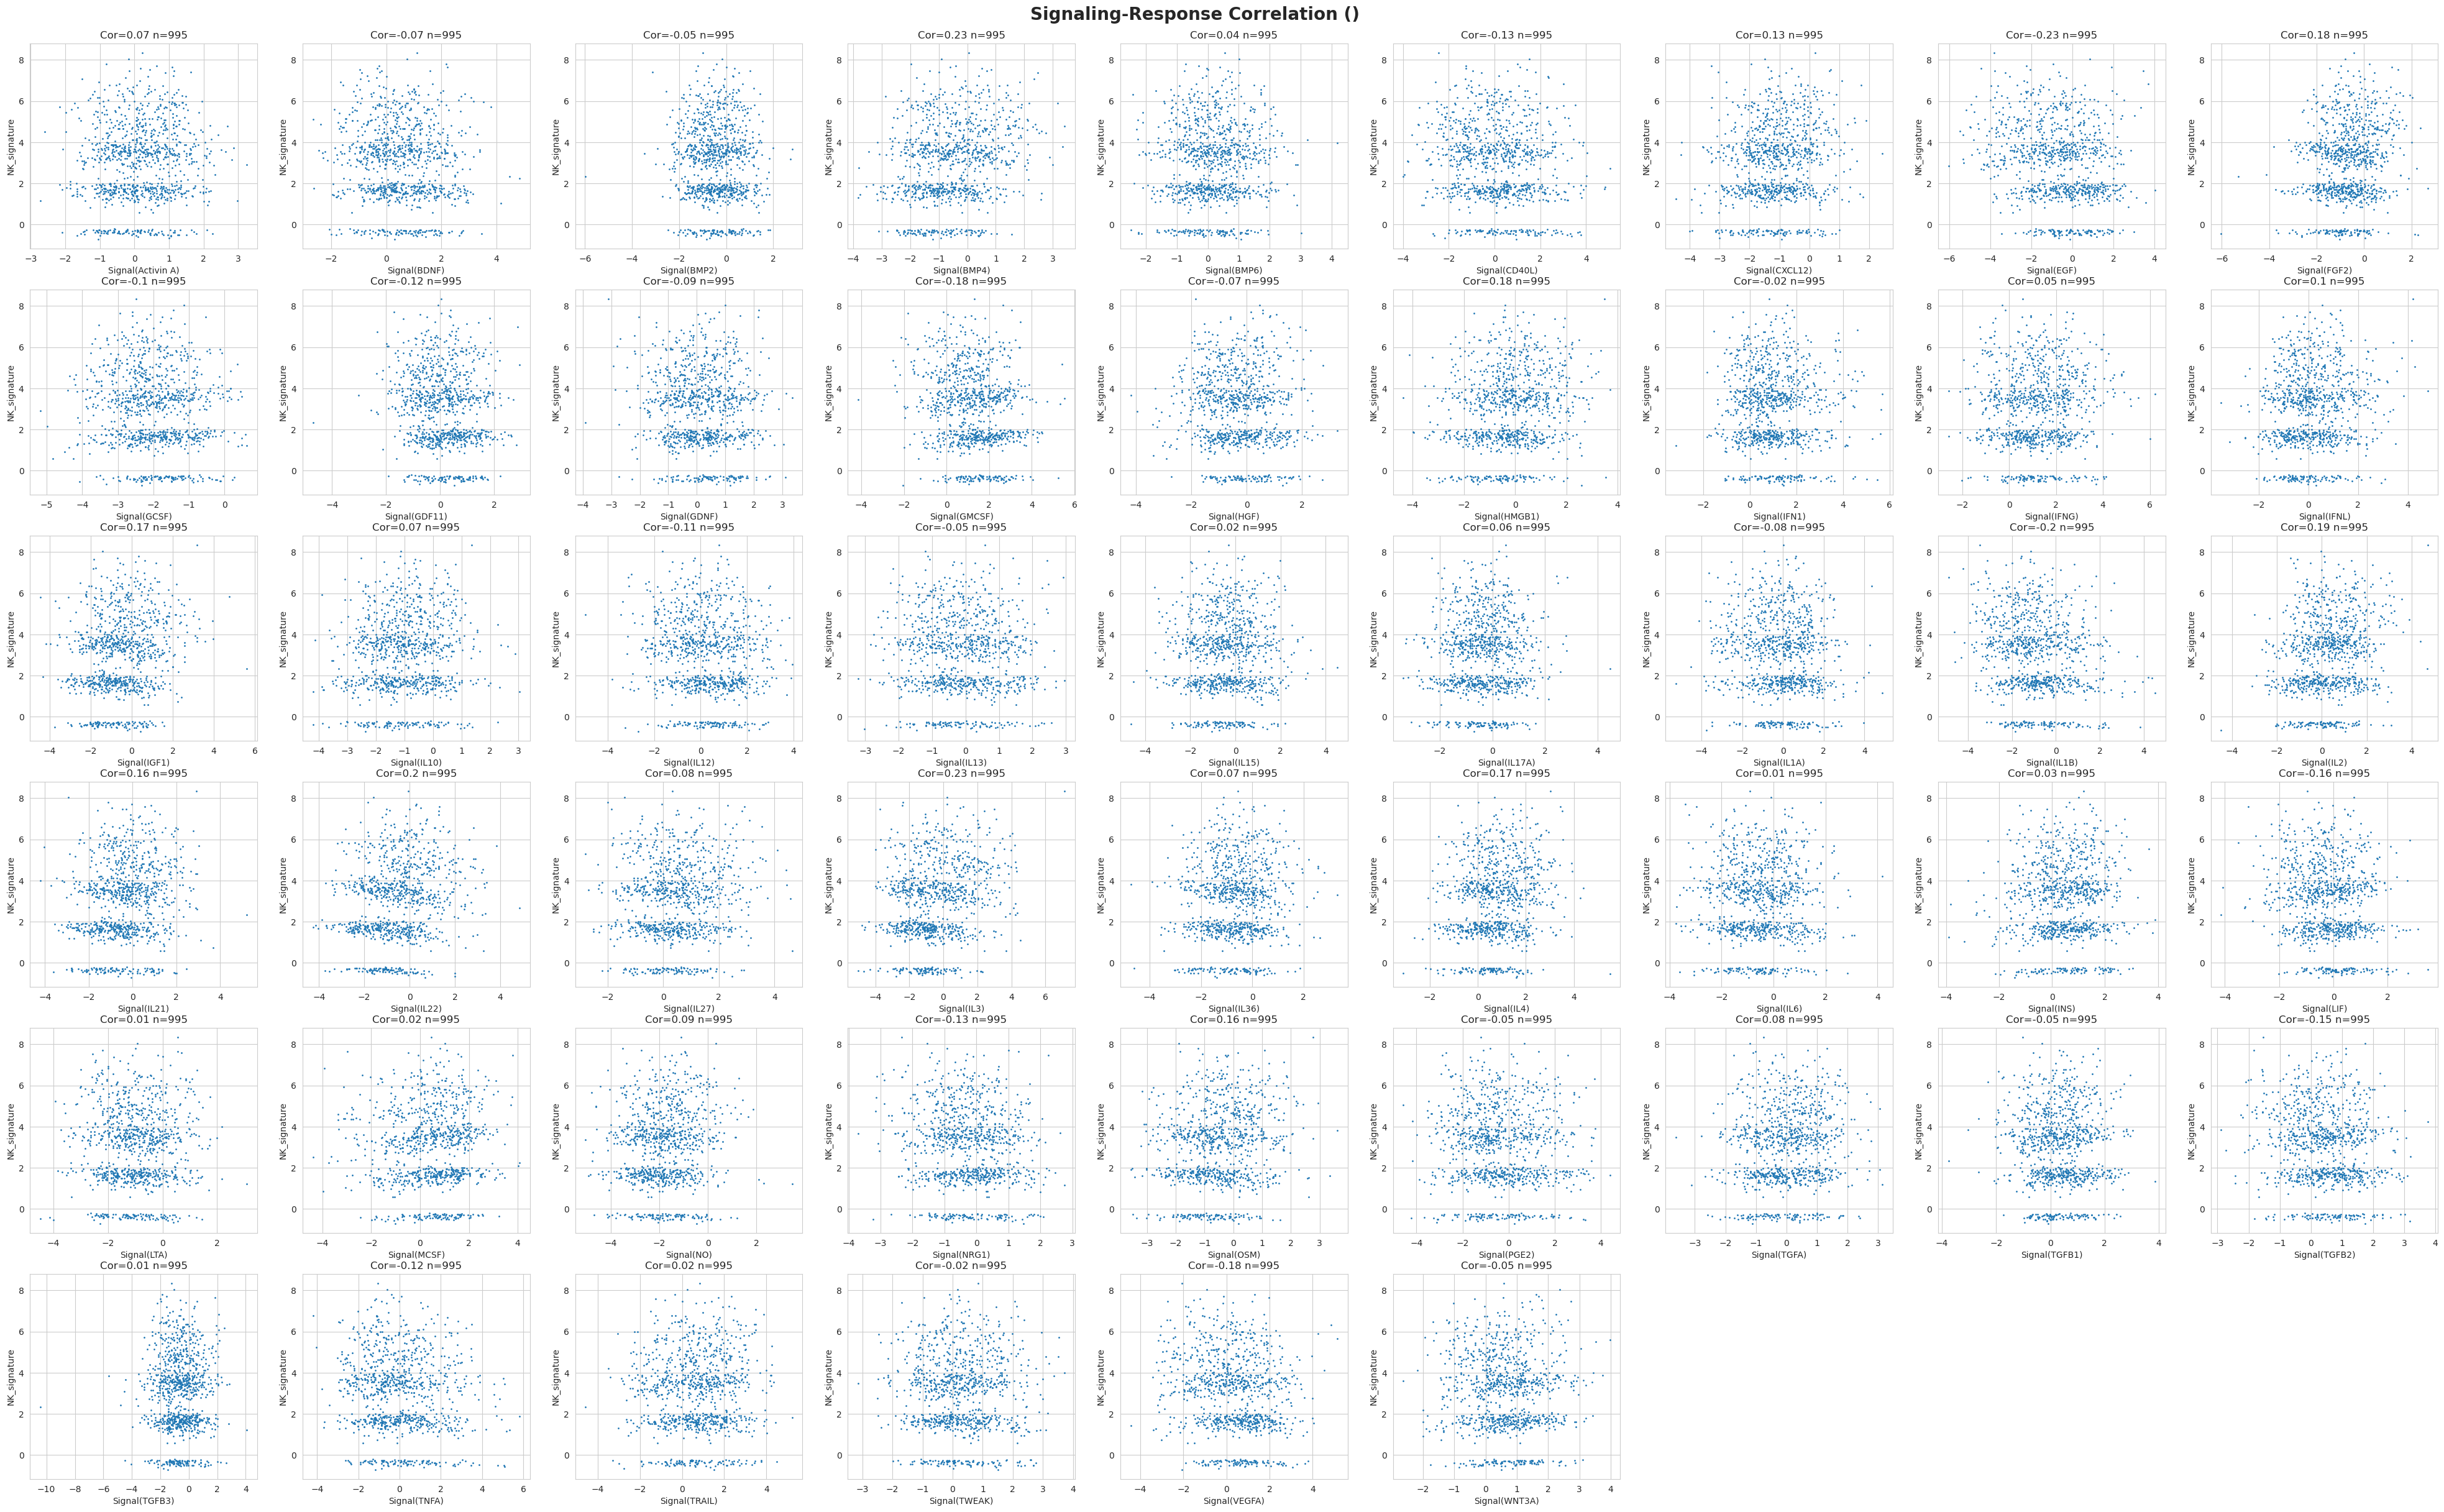

In [9]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

fig = plt.figure(figsize=(50, 30))
ncols, nrows = 9, 6
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=[1] * ncols, height_ratios=[1] * nrows)

y = response_data.loc[signature]
i = 0
for cytokine in list(signaling_data.index):
    col = i % ncols
    row = int(i / ncols)
    ax = fig.add_subplot(gs[row, col])

    x = signaling_data.loc[cytokine]
    
    # x_normalized = (x - min(x)) / (max(x) - min(x))
    # y_normalized = (y - min(y)) / (max(y) - min(y))
    correlation, _ = pearsonr(x, y)
    
    ax.scatter(x, y, s=1)
    ax.set_xlabel(f'Signal({cytokine})')
    ax.set_ylabel(signature)
    ax.set_title(f'Cor={round(correlation, 2)} n={len(x)}')
    i += 1
fig.suptitle(f"Signaling-Response Correlation ({sample})", fontsize=20, fontweight='bold', y=0.9)
plt.show()

## Response和Signaling相关性系数总结

/var/tmp/ipykernel_197196/2989165209.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)


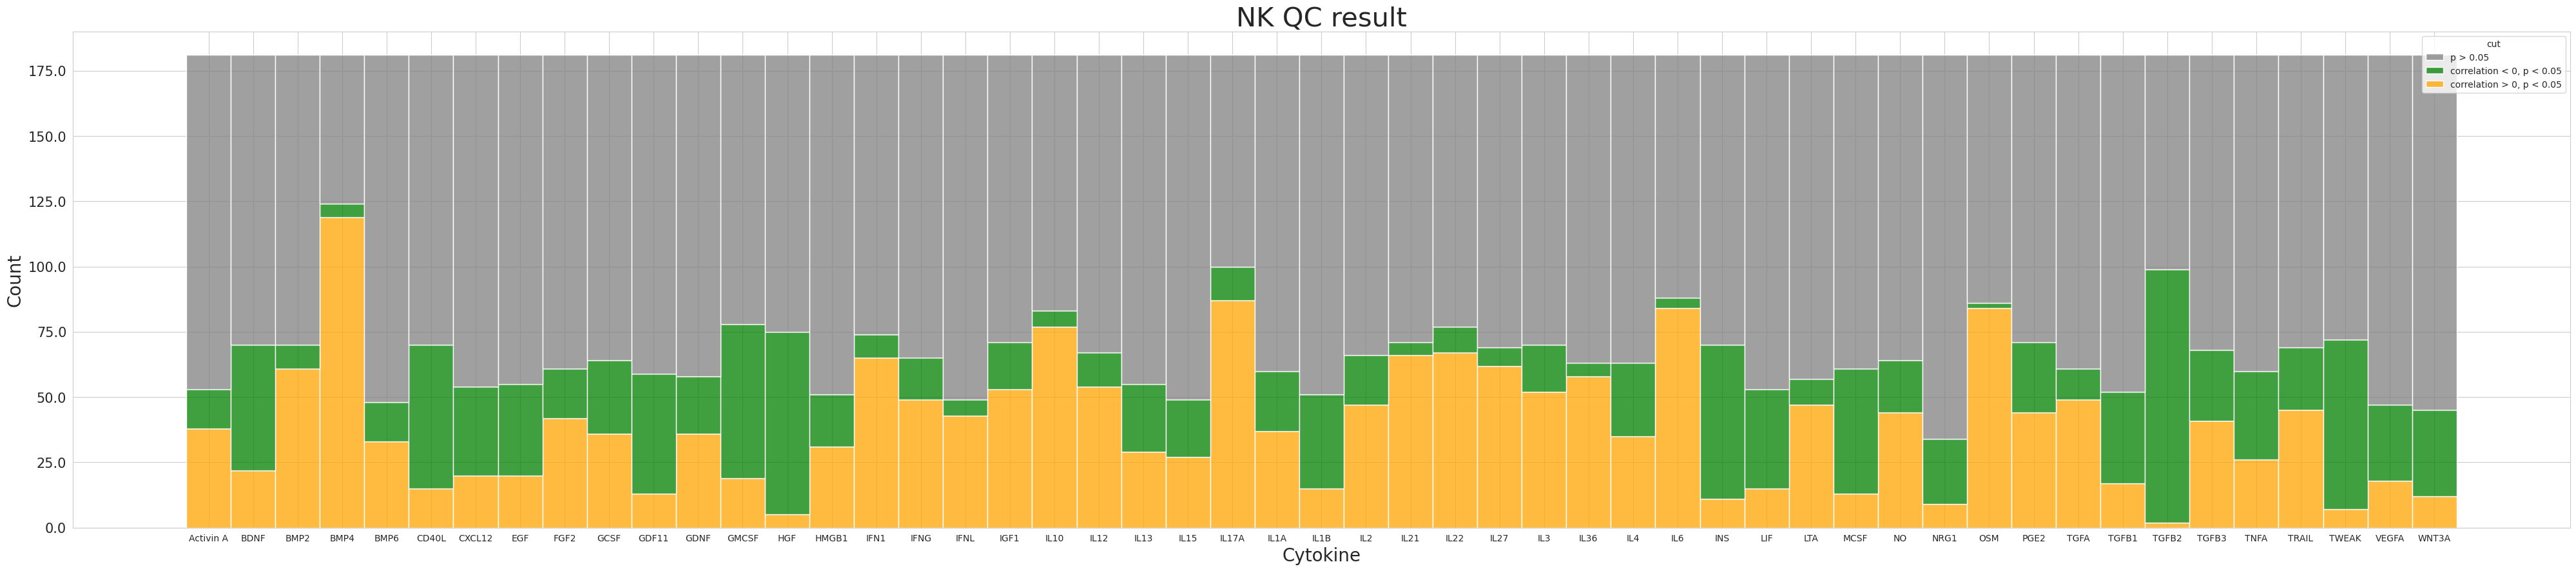

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# celltype_list = ['CD8T', 'Macrophage', 'Neutrophils', 'NK']
celltype_list = ['NK']
fig = plt.figure(figsize=(50, 10 * len(celltype_list)))
gs = gridspec.GridSpec(nrows=len(celltype_list), ncols=1)

i = 0
for celltype in celltype_list:
    # if celltype == 'Neutrophils':
    #     qc_result_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/qc_result.Neutrophils.csv'
    # else:
    qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result_correlation.{celltype}.csv'
    qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)
    
    cutoff = 0
    positive_str = f"correlation > {cutoff}, p < 0.05"
    negative_str = f"correlation < {cutoff * -1}, p < 0.05"
    unvalid_str = "p > 0.05"
    def get_group(x):
        if x.correlation >= cutoff and x.p <= 0.05:
            return positive_str
        elif x.correlation <= (cutoff * -1) and x.p <= 0.05:
            return negative_str
        elif x.p > 0.05:
            return unvalid_str
    qc_result_data['cut'] = qc_result_data.apply(lambda x: get_group(x), axis=1)
    
    def get_group2(x):
        if x.correlation >= cutoff and x.p <= 0.05:
            return 0
        elif x.correlation <= (cutoff * -1) and x.p <= 0.05:
            return 1
        elif x.p > 0.05:
            return -1

    qc_result_data['negative_rate'] = qc_result_data.apply(lambda x: get_group2(x), axis=1)
    qc_result_filtered = qc_result_data[qc_result_data['negative_rate'] >= 0]
    negative_rate = qc_result_filtered.groupby('Cytokine')['negative_rate'].mean()
    negative_rate.sort_values(ascending=False, inplace=True)
    negative_rate.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank_new.{celltype}.csv")
    
    ax = fig.add_subplot(gs[i, 0])
    histplot = sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", hue_order=[unvalid_str, negative_str, positive_str], 
                            palette={positive_str:'orange', negative_str:'green', unvalid_str:'grey'})
    histplot.xaxis.label.set_size(20)
    histplot.yaxis.label.set_size(20)
    histplot.set_yticklabels(histplot.get_yticks(), size = 15)
    histplot.set_title(f"{celltype} QC result", size = 30)
    i += 1
plt.show()

In [32]:
negative_rate

Cytokine
TGFB2             0.979592
HGF               0.945946
TWEAK             0.901408
INS               0.855072
MCSF              0.800000
CD40L             0.797101
GDF11             0.779661
GMCSF             0.766234
WNT3A             0.733333
LIF               0.730769
NRG1              0.727273
IL1B              0.720000
BDNF              0.685714
TGFB1             0.673077
EGF               0.648148
CXCL12            0.641509
VEGFA             0.630435
TNFA              0.576271
IL13              0.472727
GCSF              0.444444
IL15              0.437500
IL4               0.435484
HMGB1             0.400000
TGFB3             0.397059
IL1A              0.389831
PGE2              0.385714
GDNF              0.379310
TRAIL             0.352941
NO                0.317460
FGF2              0.316667
BMP6              0.297872
IL2               0.292308
Activin A         0.283019
IL3               0.260870
IGF1              0.253521
IFNG              0.250000
TGFA              0

ValueError: The palette dictionary is missing keys: {'correlation < -0.3, p < 0.05', 'correlation > 0.3, p < 0.05'}

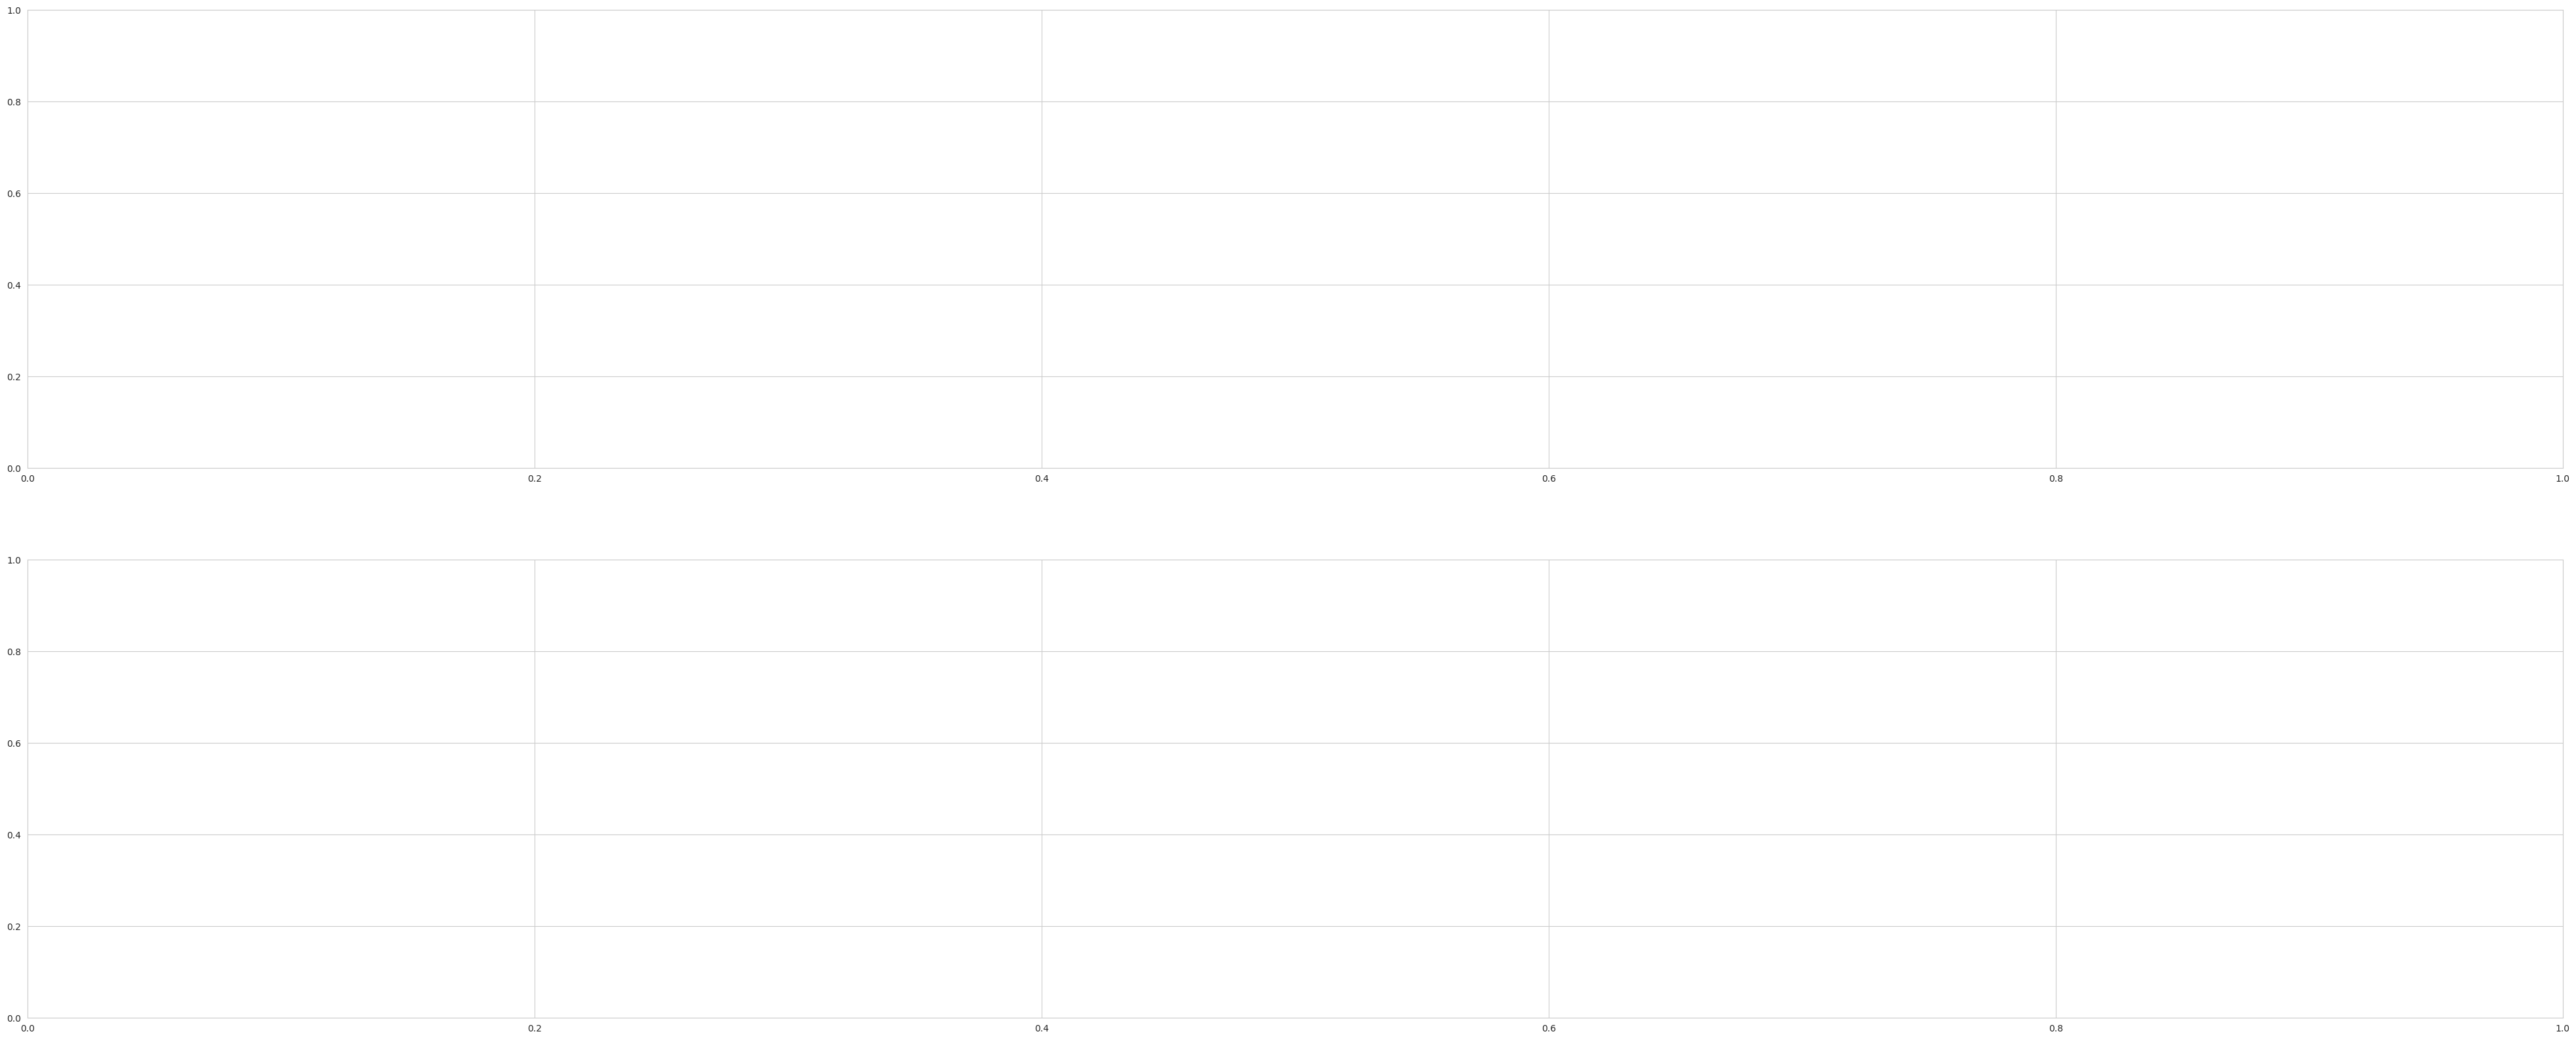

In [76]:
# 加上散点图
fig, axes = plt.subplots(2, 1, figsize=(50, 20))
sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", ax=axes[0], 
            palette={'t > 0, p < 0.05':'orange', 't < 0, p < 0.05':'green', 'p > 0.05':'grey'})
axes[0].set_title(f"{celltype} Response-Signaling t-value rate", size=30)
# qc_result_data_filtered = qc_result_data[qc_result_data['p'] <= 0.05]
sns.violinplot(x="Cytokine", y="t", data=qc_result_data, ax=axes[1])
sns.stripplot(x="Cytokine", y="t", data=qc_result_data, color='b', size=1, ax=axes[1])
axes[1].axhline(0, color='grey', linestyle='--', linewidth=2)
axes[1].set_title(f"{celltype} Response-Signaling t-value distribution (p < 0.05)", size=30)
plt.show()

## CD8T两个数据集结果汇总

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

celltype = 'CD8T'
qc_result_path1 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/1.paper_data/3.qc_result/qc_result.CD8T.csv'
qc_result_path2 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.CD8T.csv'
qc_result_data1 = pd.read_csv(qc_result_path1, sep="\t", header=0)
qc_result_data2 = pd.read_csv(qc_result_path2, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data1['cut'] = qc_result_data1.apply(lambda x: get_group(x), axis=1)
qc_result_data2['cut'] = qc_result_data2.apply(lambda x: get_group(x), axis=1)
qc_result_filtered1 = qc_result_data1[qc_result_data1['cut'] >= 0]
qc_result_filtered2 = qc_result_data2[qc_result_data2['cut'] >= 0]

qc_result_groupby_Cytokine1 = qc_result_filtered1.groupby('Cytokine')
qc_result_groupby_Cytokine2 = qc_result_filtered2.groupby('Cytokine')

cut_mean1 = qc_result_groupby_Cytokine1['cut'].mean()
cut_mean2 = qc_result_groupby_Cytokine2['cut'].mean()

X = cut_mean1.values
Y = cut_mean2.values
label = cut_mean1.index

# save the t<0 rate rank
rank_table = pd.DataFrame(index=label, columns=['Cohort_rank', 'Tisch_rank', 'average'])
Cohort_rank = scipy.stats.rankdata(X, method='min')
Tisch_rank = scipy.stats.rankdata(Y, method='min')
average = (Cohort_rank + Tisch_rank) / 2
rank_table['Cohort_rank'] = Cohort_rank
rank_table['Tisch_rank'] = Tisch_rank
rank_table['average'] = average
rank_table_sort = rank_table.sort_values(by='average')
rank_table_sort.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")

fig = plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
for i in range(len(X)):
    plt.annotate(label[i], xy = (X[i], Y[i]), xytext = (X[i], Y[i]), fontsize = 5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Cohort_Tisch Cytokine t<0 rate')
plt.xlabel('Cohort')
plt.ylabel('Tisch')
plt.show()

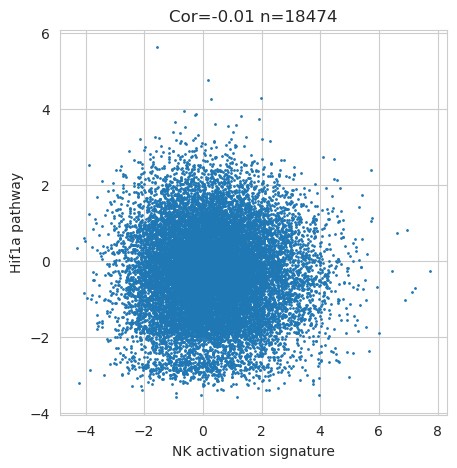

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

celltype = 'NK'
dataset = 'NPC_GSE162025'
sample = ''

signature = 'Hif1a_signature'
signaling_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-4.NK_response/{dataset}.csv'
response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-4-2.Hif1a_response/{dataset}.csv'

signaling_data = pd.read_csv(signaling_path, delimiter='\t', index_col=0, header=0)
celltype_list = [v.split('.')[0] for v in signaling_data.columns]
celltype_flag = [v for v in signaling_data.columns if v.split('.')[0] == celltype]
signaling_data = signaling_data[celltype_flag]
response_data = pd.read_csv(response_path, delimiter='\t', index_col=0, header=0)

if sample != '':
    sample_flag = [v for v in response_data.columns if '.'.join(v.split('.')[:2]) == sample]
    signaling_data = signaling_data[sample_flag]
    sample_flag = [v for v in signaling_data.columns if '.'.join(v.split('.')[:2]) == sample]
    response_data = response_data[sample_flag]

fig = plt.figure(figsize=(5, 5))
ncols, nrows = 1, 1
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=[1] * ncols, height_ratios=[1] * nrows)

y = response_data.loc[signature]
col = 0
row = 0
ax = fig.add_subplot(gs[row, col])

x = signaling_data.loc['NK_signature']
correlation, _ = pearsonr(x, y)
    
ax.scatter(x, y, s=1)
ax.set_xlabel('NK activation signature')
ax.set_ylabel('Hif1a pathway')
ax.set_title(f'Cor={round(correlation, 2)} n={len(x)}')

# fig.suptitle(f"NFkB-NK Correlation ({sample})", fontsize=20, fontweight='bold', y=0.9)
plt.show()


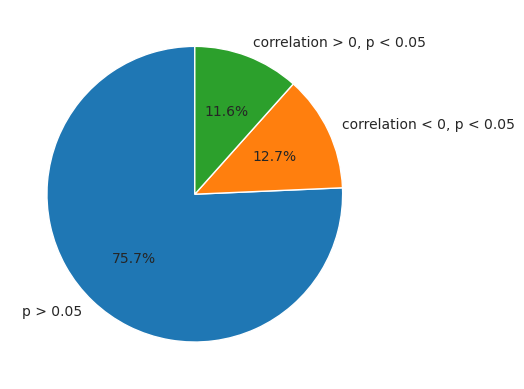

In [118]:
data_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result_correlation.Hif1a.csv'
data = pd.read_csv(data_path, delimiter='\t', index_col=0, header=0).dropna()

# correlation = data[data['p'] < 0.05]['correlation']
# correlation = np.nan_to_num(data['correlation'], nan=0.0, copy=True)
def get_group(x):
    if x.correlation >= 0 and x.p <= 0.05:
        return f"correlation > 0, p < 0.05"
    elif x.correlation <= 0 and x.p <= 0.05:
        return f"correlation < 0, p < 0.05"
    elif x.p > 0.05:
        return "p > 0.05"

data['group'] = data.apply(lambda x: get_group(x), axis=1)
value_counts  = pd.DataFrame(data['group'].value_counts())

# 绘制饼图
plt.pie(value_counts['count'], labels=value_counts.index, autopct='%1.1f%%', startangle=90)

# 绘制箱线图
# plt.boxplot(correlation)
# plt.title("Correlation(p<0.05)")
# 显示图形
plt.show()

In [119]:
value_counts

,count
group,
p > 0.05,137
"correlation < 0, p < 0.05",23
"correlation > 0, p < 0.05",21
